<a href="https://colab.research.google.com/github/kjaron83/tensorflow-tutorials/blob/master/classification/intel_image_classification/03.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Processing the [Intel natural scenes](https://www.kaggle.com/puneet6060/intel-image-classification) dataset.

This time I use transfer learning and fine tuning. Last time EfficientNetB0 performed best so I use this model for the experience.

In [1]:
# Download the helper functions
!wget https://raw.githubusercontent.com/kjaron83/tensorflow-tutorials/master/functions/helper.py

--2022-03-10 15:59:03--  https://raw.githubusercontent.com/kjaron83/tensorflow-tutorials/master/functions/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4892 (4.8K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]   4.78K  --.-KB/s    in 0s      

2022-03-10 15:59:04 (54.2 MB/s) - ‘helper.py’ saved [4892/4892]



In [2]:
# Are we using a GPU?
!nvidia-smi

Thu Mar 10 15:59:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    28W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
# Download and extract the dataset
from helper import extract
# Train data
extract("https://archive.org/download/seg_train/seg_train.zip")
# Test data
extract("https://archive.org/download/seg_test/seg_test.zip")

44646400/44635476 [==============================] - 55s 1us/step


Skipping data visualization. See: [01.ipynb](https://github.com/kjaron83/tensorflow-tutorials/blob/master/classification/intel_image_classification/01.ipynb)

In [5]:
# Setup the train and test directories
train_dir = "/content/seg_train"
test_dir = "/content/seg_test"

# Make sure we use the same image shape everywhere
TARGET_SIZE = (224, 224)
INPUT_SHAPE = TARGET_SIZE + (3,)

# Batch size for good health
BATCH_SIZE = 32

# Using the same epochs everywhere
EPOCHS = 5

# Same random seed for repeatable results
RANDOM_SEED = 42

In [6]:
# Get the class names for our multi-class dataset
from helper import class_names
class_names = class_names(train_dir)
print(class_names)

['buildings' 'forest' 'glacier' 'mountain' 'sea' 'street']


In [7]:
# We have 6 classes so this is a categorical classification problem
CLASS_COUNT = len(class_names)
CLASS_MODE = "categorical"

## Using the image_data_from_directory function

Now we've got some image data, we need a way of loading it into a TensorFlow compatible format.

Previously, we've used the ImageDataGenerator class. And while this works well and is still very commonly used, this time we're going to use the image_data_from_directory function.

It works much the same way as ImageDataGenerator's flow_from_directory method.

In [8]:
# Create data inputs
import tensorflow as tf
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                 image_size=TARGET_SIZE,
                                                                 label_mode=CLASS_MODE,
                                                                 batch_size=BATCH_SIZE)
test_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=TARGET_SIZE,
                                                                label_mode=CLASS_MODE)

Found 14034 files belonging to 6 classes.
Found 3000 files belonging to 6 classes.


## Creating data augmentation layer

In [9]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

# Create a data augmentation stage with horizontal flipping, rotations, zooms
def create_data_augmentation_model():
  return keras.Sequential([
                           preprocessing.RandomFlip("horizontal"),
                           preprocessing.RandomRotation(0.2),
                           preprocessing.RandomZoom(0.2),
                           preprocessing.RandomHeight(0.2),
                           preprocessing.RandomWidth(0.2),
                           # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
                           ], name ="data_augmentation")

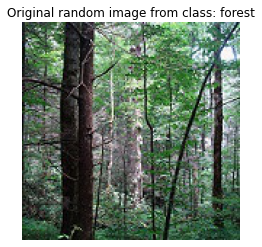

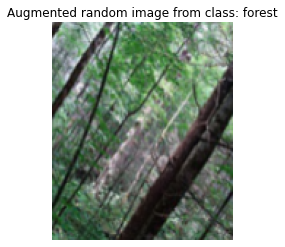

In [10]:
# View a random image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random

target_class = random.choice(train_data.class_names) # choose a random class
target_dir = train_dir + "/" + target_class # create the target directory
random_image = random.choice(os.listdir(target_dir)) # choose a random image from target directory
random_image_path = target_dir + "/" + random_image # create the choosen random image path
img = mpimg.imread(random_image_path) # read in the chosen target image
plt.imshow(img) # plot the target image
plt.title(f"Original random image from class: {target_class}")
plt.axis(False); # turn off the axes

data_augmentation = create_data_augmentation_model()
# Augment the image
augmented_img = data_augmentation(img) # data augmentation model requires shape (None, height, width, 3)
plt.figure()
plt.imshow(augmented_img/255.) # requires normalization after augmentation
plt.title(f"Augmented random image from class: {target_class}")
plt.axis(False);

## Building a transfer learning model using the Keras Functional API

In [11]:
# Importing the create tensorboard callback function
from helper import create_tensorboard_callback

In [12]:
# 1. Create base model with tf.keras.applications
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freeze the base model (so the pre-learned patterns remain)
base_model.trainable = False

# 3. Create inputs into the base model
inputs = tf.keras.layers.Input(shape=INPUT_SHAPE, name="input_layer")
print(f"Shape after input_layer: {inputs.shape}")

# 4. Add in data augmentation Sequential model as a layer
data_augmentation = create_data_augmentation_model()
x = data_augmentation(inputs)
print(f"Shape after data_augmentation: {x.shape}")

# 5. Pass the inputs to the base_model (note: using tf.keras.applications, EfficientNet inputs don't have to be normalized)
x = base_model(x)
# Check data shape after passing it to base_model
print(f"Shape after base_model: {x.shape}")

# 6. Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)
print(f"After GlobalAveragePooling2D(): {x.shape}")

# 7. Create the output activation layer
outputs = tf.keras.layers.Dense(CLASS_COUNT, activation="softmax", name="output_layer")(x)

# 8. Combine the inputs with the outputs into a model
model_1 = tf.keras.Model(inputs, outputs)

# 9. Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

16719872/16705208 [==============================] - 0s 0us/step
Shape after input_layer: (None, 224, 224, 3)
Shape after data_augmentation: (None, 224, 224, 3)
Shape after base_model: (None, 7, 7, 1280)
After GlobalAveragePooling2D(): (None, 1280)


In [13]:
# 10. Fit the model (we use less steps for validation so it's faster)

initial_epochs = EPOCHS

history_1 = model_1.fit(train_data,
                        epochs=initial_epochs,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        # Go through less of the validation data so epochs are faster (we want faster experiments!)
                        validation_steps=int(0.25 * len(test_data)), 
                        # Track our model's training logs for visualization later
                        callbacks=[create_tensorboard_callback("transfer_learning", "model_1")])

Saving TensorBoard log files to: transfer_learning/model_1/20220310-161556
Epoch 1/5
439/439 [==============================] - 257s 546ms/step - loss: 0.5070 - accuracy: 0.8230 - val_loss: 0.3178 - val_accuracy: 0.8886
Epoch 2/5
439/439 [==============================] - 187s 425ms/step - loss: 0.3472 - accuracy: 0.8748 - val_loss: 0.3228 - val_accuracy: 0.8886
Epoch 3/5
439/439 [==============================] - 160s 364ms/step - loss: 0.3283 - accuracy: 0.8774 - val_loss: 0.2849 - val_accuracy: 0.9035
Epoch 4/5
439/439 [==============================] - 144s 327ms/step - loss: 0.3062 - accuracy: 0.8894 - val_loss: 0.2892 - val_accuracy: 0.9008
Epoch 5/5
439/439 [==============================] - 130s 295ms/step - loss: 0.3014 - accuracy: 0.8880 - val_loss: 0.2649 - val_accuracy: 0.9158


In [14]:
model_1.save("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/EfficientNetB0_base.h5")

In [15]:
model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/EfficientNetB0_base.h5")
model_2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling_laye  (None, 1280)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 6)                 7686      
                                                                 
Total params: 4,057,257
Trainable params: 7,686
Non-trainable

In [16]:
# Check which layers are tuneable in the whole model
for layer in model_2.layers:
  print(layer.trainable)

True
True
True
True
True


In [17]:
# Check which layers are tuneable (trainable)
base_model = model_2.layers[2]
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 True
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape Fa

To begin fine-tuning, we'll unfreeze the entire base model by setting its trainable attribute to True. Then we'll refreeze every layer in the base model except for the last 10 by looping through them and setting their trainable attribute to False. Finally, we'll recompile the model.

In [18]:
base_model.trainable = True

# Freeze all layers except for the
for layer in base_model.layers[:-10]:
  layer.trainable = False

# Recompile the model (always recompile after any adjustments to a model)
model_2.compile(loss="categorical_crossentropy",
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), # lr is 10x lower than before for fine-tuning
              metrics=["accuracy"])

In [19]:
# Check which layers are tuneable in the whole model
for layer in model_2.layers:
  print(layer.trainable)

True
True
True
True
True


In [20]:
# Check which layers are tuneable (trainable)
for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_reshape F

In [21]:
# Fine tune for another 5 epochs
fine_tune_epochs = initial_epochs + 5

# Refit the model (same as model_2 except with more trainable layers)
history_2 = model_2.fit(train_data,
                        epochs=fine_tune_epochs,
                        validation_data=test_data,
                        initial_epoch=history_1.epoch[-1], # start from previous last epoch
                        validation_steps=int(0.25 * len(test_data)),
                        callbacks=[create_tensorboard_callback("transfer_learning", "model_2")]) # name experiment appropriately


Saving TensorBoard log files to: transfer_learning/model_2/20220310-163216
Epoch 5/10
439/439 [==============================] - 143s 306ms/step - loss: 0.3027 - accuracy: 0.8877 - val_loss: 0.2471 - val_accuracy: 0.9130
Epoch 6/10
439/439 [==============================] - 126s 287ms/step - loss: 0.2732 - accuracy: 0.9000 - val_loss: 0.2378 - val_accuracy: 0.9185
Epoch 7/10
439/439 [==============================] - 122s 278ms/step - loss: 0.2491 - accuracy: 0.9065 - val_loss: 0.2265 - val_accuracy: 0.9185
Epoch 8/10
439/439 [==============================] - 118s 267ms/step - loss: 0.2381 - accuracy: 0.9121 - val_loss: 0.1997 - val_accuracy: 0.9334
Epoch 9/10
439/439 [==============================] - 113s 256ms/step - loss: 0.2250 - accuracy: 0.9173 - val_loss: 0.2411 - val_accuracy: 0.9266
Epoch 10/10
439/439 [==============================] - 110s 250ms/step - loss: 0.2108 - accuracy: 0.9220 - val_loss: 0.2124 - val_accuracy: 0.9348


In [22]:
model_2.save("/content/drive/MyDrive/Colab Notebooks/intel_image_classification/EfficientNetB0_fine_tuned.h5")

In [23]:
model_1.evaluate(test_data)

94/94 [==============================] - 18s 183ms/step - loss: 0.2596 - accuracy: 0.9077


[0.25964999198913574, 0.9076666831970215]

In [24]:
model_2.evaluate(test_data)

94/94 [==============================] - 17s 175ms/step - loss: 0.1976 - accuracy: 0.9257


[0.1976286619901657, 0.9256666898727417]

In [25]:
from sklearn.utils import shuffle
pred_data = tf.keras.preprocessing.image_dataset_from_directory(directory=test_dir,
                                                                image_size=TARGET_SIZE,
                                                                label_mode=CLASS_MODE,
                                                                shuffle=False)

Found 3000 files belonging to 6 classes.


In [26]:
import numpy as np
Y_true = np.concatenate([y for x, y in pred_data], axis=0)
y_true = np.argmax(Y_true, axis=1)

Y_pred = model_2.predict(pred_data)
y_pred = np.argmax(Y_pred, axis=1)

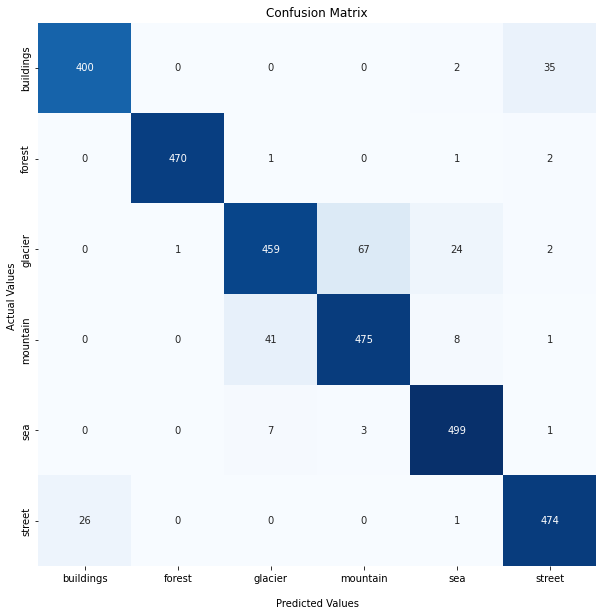

In [27]:
from helper import plot_confusion_matrix
plot_confusion_matrix(y_true, y_pred, class_names)

5
11
[0.8230012655258179, 0.8748040199279785, 0.8774405121803284, 0.889411449432373, 0.8879863023757935, 0.8877012729644775, 0.9000285267829895, 0.9065127372741699, 0.9120706915855408, 0.9173436164855957, 0.9219751954078674]


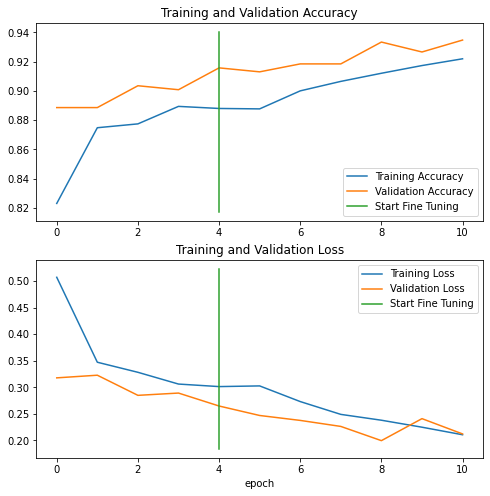

In [28]:
# Let's see what happened after fine-tuning the last 10 layers of our model.
from helper import compare_histories

compare_histories(original_history=history_1, 
                 new_history=history_2, 
                 initial_epochs=initial_epochs)

In [ ]:
# View tensorboard logs of transfer learning modelling experiments
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./transfer_learning \
  --name "EfficientNetB0 fine tuning experiences" \
  --description "Using EfficientNetB0 on the Intel natural scenes dataset.yes" \
  --one_shot # exits the uploader when upload has finished

View your TensorBoard at https://tensorboard.dev/experiment/68bESRTPRbem0LOQzAOEYA/